Ideally a quantum computer is a closed system -> no energy loss \
IRL an interaction is required, both for initialization, manipulation and readout

In [3]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library.standard_gates import XGate, ZGate

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2, QiskitRuntimeService

from qiskit_aer import AerSimulator

import matplotlib.pyplot as plt

In [4]:
# token = ''
# with open('token.tmp', encoding='utf-8') as f:
#     token = f.read()

# QiskitRuntimeService.save_account(
#     channel="ibm_quantum",
#     token=token,
#     set_as_default=True,
#     overwrite=True,
# )

# service = QiskitRuntimeService()

In [19]:
def teleport(circuit: QuantumCircuit, fromQubit: QuantumRegister, toQubit:QuantumRegister):

    # Create support registers required to perform teleportation
    tmp = QuantumRegister(1, 'tmp')
    circuit.add_register(tmp)

    cx = ClassicalRegister(1, 'cx')
    circuit.add_register(cx)

    cz = ClassicalRegister(1, 'cz')
    circuit.add_register(cz)
    
    circuit.barrier()


    # Share Bell pair
    circuit.h(tmp)
    circuit.cx(tmp, toQubit)
    circuit.barrier()


    # Prepare to measure x on tmp and z on alice
    circuit.cx(fromQubit, tmp)
    circuit.h(fromQubit)
    circuit.barrier()


    #Measure
    circuit.measure(fromQubit, cz)
    circuit.measure(tmp, cx)


    #Apply proper gates
    circuit.append(ZGate(), toQubit).c_if(cz, 1)
    circuit.append(XGate(), toQubit).c_if(cx, 1)

    circuit.barrier()


In [20]:
def getFullCircuit(tryTeleport = True):

    alice = QuantumRegister(1, name='Alice')
    bob = QuantumRegister(1, name='Bob')
    out = ClassicalRegister(1, 'out')
    
    qc = QuantumCircuit(alice, bob, out) if tryTeleport else QuantumCircuit(alice, out)
    # State preparation
    getTestState(qc, alice)

    # Teleport
    if tryTeleport:
        teleport(qc, alice, bob)

    # Measure
    qc.measure(bob if tryTeleport else alice, out)
    return qc

In [21]:
def runAndShow(qc: QuantumCircuit, noisy=True, shots = 1024):
    backend = FakeManilaV2() if noisy else AerSimulator()

    # You can use a fixed seed to get fixed results.
    result = SamplerV2(backend).run([
        generate_preset_pass_manager(backend=backend, optimization_level=0)
            .run(qc)
    ], shots=shots).result()

    retDict = result[0].data.out.get_counts()
    print(retDict)
    retDict = { k:retDict[k]/shots for k in sorted(retDict) }
    # return plt.bar(['0', '1'], [retDict['0'], retDict['1']])
    return plt.bar(retDict.keys(), retDict.values())

In [22]:
def getTestState(qc: QuantumCircuit, testQubit: QuantumRegister):
    qc.x(testQubit)
    return

{'1': 965, '0': 59}
{'1': 862, '0': 162}


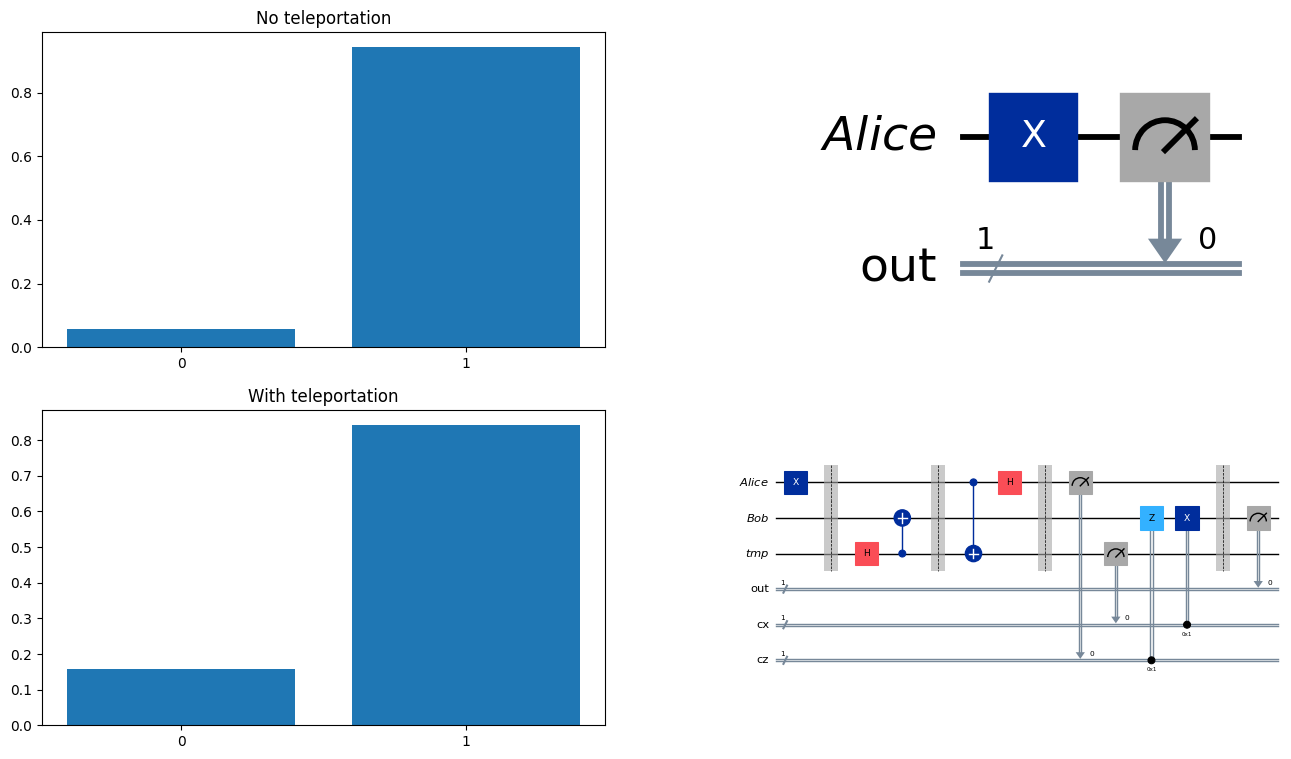

In [23]:
plt.figure(figsize=(16, 9))

noisySimulation = True

qc = getFullCircuit(tryTeleport=False)
qcTele = getFullCircuit(tryTeleport=True)


plt.subplot(2, 2, 1)
runAndShow(qc, noisy=noisySimulation)
plt.gca().title.set_text('No teleportation')

plt.subplot(2, 2, 2)
qc.draw('mpl', ax=plt.gca())


plt.subplot(2, 2, 3)
runAndShow(qcTele, noisy=noisySimulation)
plt.gca().title.set_text('With teleportation')

plt.subplot(2, 2, 4)
qcTele.draw('mpl', ax=plt.gca())

# Below cell was just a test to provide a quantum circuit for state teleportation

Text(0.5, 1.0, 'Quantum teleportation algorithm')

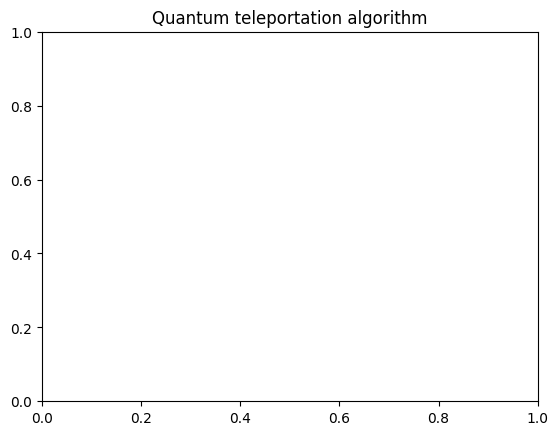

In [10]:
# Teleportation circuit
alice = QuantumRegister(1, name='Alice')
tmp = QuantumRegister(1, name='tmp')
bob = QuantumRegister(1, name='Bob')

cx = ClassicalRegister(1, name='cx')
cz = ClassicalRegister(1, name='cz')

tp = QuantumCircuit(alice, tmp, bob, cx, cz, name='Quantum teleportation')

tp.barrier()

tp.h(tmp)
tp.cx(tmp, bob)

tp.barrier()

tp.cx(alice, tmp)
tp.h(alice)

tp.barrier()

tp.measure(alice, cz)
tp.measure(tmp, cx)

tp.append(XGate(), bob).c_if(cx, 1)
tp.append(ZGate(), bob).c_if(cz, 1)

tp.barrier()

tp.draw('mpl')
plt.title('Quantum teleportation algorithm')